In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Read The Data From train.csv

In [2]:
passengers = pd.read_csv('data\\train.csv')
passengers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Find The Features That Have Null Value

In [3]:
passengers.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Handle Null Values In Cabin Feature, Age And Embarked

In [4]:
passengers['have_cabin'] = passengers['Cabin'].notnull().astype('int')
passengers['Age'] = passengers['Age'].fillna(int(np.mean(passengers['Age'])))
passengers['Age'] = passengers['Age'].astype(int)
passengers['Embarked'] = passengers['Embarked'].fillna(passengers['Embarked'].mode())

Aggregate Features SibSp And Parch To Create Feature FamilySize

c:\users\arash\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


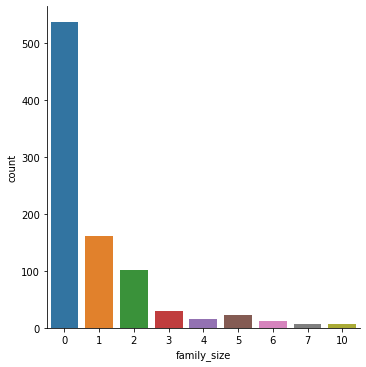

0       7
1      71
2       7
3      53
4       8
       ..
886    13
887    30
888    23
889    30
890     7
Name: Fare, Length: 891, dtype: int32

In [5]:
passengers['family_size'] = passengers['SibSp'] + passengers['Parch']
passengers['fare_per_person'] = passengers['Fare'] / (1+passengers['family_size']).astype('float32')
passengers['Fare'] = passengers['Fare'].astype(int)
passengers['fare_per_person'] = passengers['Fare'].astype(int)

sns.factorplot(x='family_size', data=passengers, kind='count')
plt.show()
passengers['Fare']

Create New Feature Title And Transfer It To Numeric Data

c:\users\arash\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


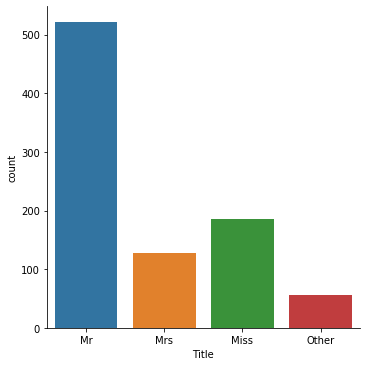

In [6]:
passengers['Title'] = passengers.Name.str.extract('([A-Za-z]+)\.')
passengers['Title'] = passengers['Title'].replace(['Miss', 'Mme','Ms','Mlle', 'Mrs', 'Lady','Countess', 'Mr', 'Dona','Major','Sir',
                             'Capt','Don','Rev','Col', 'Jonkheer','Dr', 'Master'],
                            ['Miss', 'Miss', 'Miss', 'Miss', 'Mrs', 'Mrs', 'Mrs', 'Mr',
                             'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Other', 'Other', 'Other', 'Other', 'Other'])
sns.factorplot(x='Title', data=passengers, kind='count')
plt.show()

Create New Feature age_parts

c:\users\arash\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


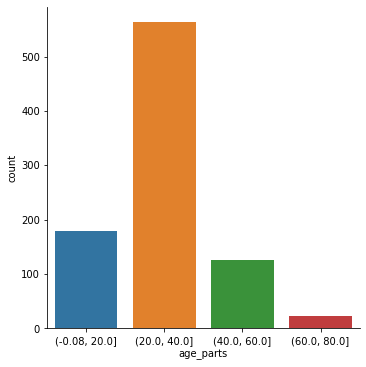

In [7]:
passengers['age_parts'] = pd.cut(passengers['Age'].astype(int), 4)
sns.factorplot(x='age_parts', data=passengers, kind='count')
plt.show()

Calculate The Similarities Between Features

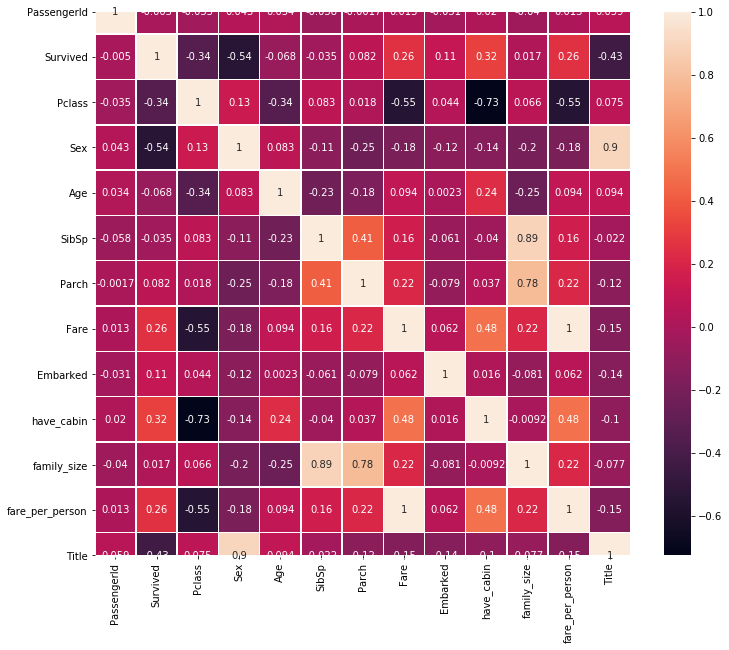

In [8]:
features = passengers.copy()
features['Sex'].replace(['female','male'], [0,1], inplace=True)
features['Embarked'] = features['Embarked'].replace(['S','C', 'Q'], [0,1,2])
features['Title'] = features['Title'].replace(['Miss', 'Mrs', 'Mr', 'Other'], [0,1,2,3])

f0, ax0 = plt.subplots(figsize=(12,10))
sns.heatmap(features.corr(), annot = True, linewidths=0.5)
plt.savefig('All_Features_CorrelationMatrix.png')
plt.show()

Remove Unnecessary Features And One Hot Encoding Categorical Features

In [9]:
passengers = passengers.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis=1)
passengers = pd.get_dummies(passengers,columns=['Title', 'Pclass', 'Embarked', 'age_parts', 'Sex'])

Feature Selection

In [10]:
X = passengers.drop('Survived', axis=1)
y = passengers['Survived']
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
model.transform(X)
mask = model.get_support(indices=False)    # this will return boolean mask for the columns
x = X.loc[:, mask]                      # the sliced dataframe, keeping selected columns
featured_col_names = X.columns
X.columns[model.get_support()]

Index(['Age', 'Fare', 'have_cabin', 'family_size', 'fare_per_person',
       'Title_Mr', 'Pclass_3', 'Sex_female'],
      dtype='object')

Plot Correlation Matrix

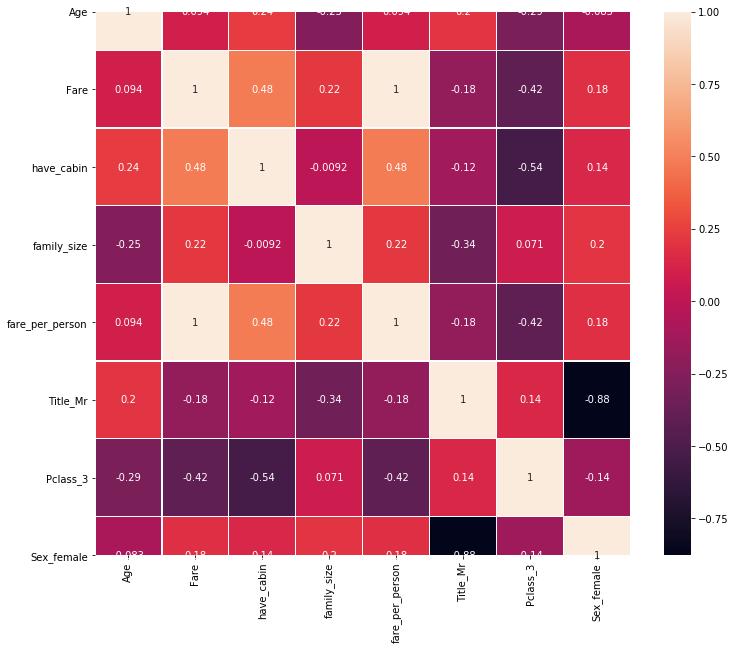

In [11]:
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(x.corr(), annot = True, linewidths=0.5)
plt.savefig('Features_CorrelationMatrix.png')
plt.show()

Preparing Test And Train Data Sets

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)



Build The Linear SVM Model

In [13]:
clf = LinearSVC(random_state=0)
clf.fit(x_train, y_train)

clf.predict(x_train)
acc_train_svm = clf.score(x_train, y_train)

pred = clf.predict(x_test)
acc_test_svm = clf.score(x_test, y_test)

print('Training Accuracy Is:', acc_train_svm)
print('Test Accuracy Is:', acc_test_svm)

Training Accuracy Is: 0.8117977528089888
Test Accuracy Is: 0.8044692737430168


c:\users\arash\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Find The Best Parameters For Non Linear SVM

In [14]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid)

Build The Non Linear SVM Model

In [15]:
grid.fit(x_train, y_train)

grid.predict(x_train)
acc_train_svm = grid.score(x_train, y_train)

pred1 = grid.predict(x_test)
acc_test_svm = grid.score(x_test, y_test)

print('Training Accuracy Is:', acc_train_svm)
print('Test Accuracy Is:', acc_test_svm)

Training Accuracy Is: 0.8230337078651685
Test Accuracy Is: 0.7988826815642458
